<a href="https://colab.research.google.com/github/lhrkkk/LFP/blob/main/all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Settings

In [64]:
#@title Global Variables {display-mode: "form"}

# 全局参数
# DATA_SOURCE='real'
DATA_SOURCE='synth'

FIND_HIGHLIGHT=True
# FIND_HIGHLIGHT=False



### 流程
1. 时频域图-》寻找高光活跃中心点-》将这些点，按频率划分到时间点集合

2. 对某一频率的时间点集，进行原始片段提取，并在此频率滤波后 -》普通聚类或 DTW距离聚类。

3. 返还到原信号时间片，对比类内样本的滤波后的波形。

这样能得到某一频率的活跃波形。并且能够按照相似性聚集类别。

In [65]:
#@title Dependences {display-mode: "form"}
# 加上这一行可折叠代码

# %%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行

!pip install numpy matplotlib mne pandas PyWavelets scikit-learn tslearn yapf scipy imageio opencv-python numba dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, Epochs
from mne.baseline import rescale
from mne.io import RawArray
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet, AverageTFR)
from mne.viz import centers_to_edges
import scipy.stats as stats

from sklearn.cluster import AgglomerativeClustering 
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage,dendrogram


print(__doc__)


Automatically created module for IPython interactive environment


# Source Data

In [67]:
#@title Real data {display-mode: "form"}

# %%script false --no-raise-error  # 真实信号
# 加上这一行可以禁止 cell 运行

if DATA_SOURCE=='real':

  ## 设定 Epoches 基本参数
  sfreq = 1250.0
  # ch_names = ['SIM0001', 'SIM0002']
  # ch_types = ['grad', 'grad']
  ch_names = ['LFP1']
  ch_types = ['seeg']  # 设定信号类型，会改变单位值
  info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
  epoch_real_time=10
  n_times = epoch_real_time*sfreq
  n_epochs = 40

  # real data
  import scipy.io as scio
  dataFile = 'VRlfp75.mat'

  data = scio.loadmat(dataFile)
  # channel0
  data=list(data['LFP_data']['lfp_ncs'][0][0].flatten())

  # 去掉末尾 0 值
  while data[-1]==0:
      del data[-1]

  # 标准化，其实不需要，MNE 会自动标准化
  data=np.array([data])
  data[0]=stats.zscore(data[0])


In [68]:
#@title Synth data {display-mode: "form"}

# %%script false --no-raise-error # 模拟信号

if DATA_SOURCE=='synth':

  ## 设定 Epoches 基本参数
  sfreq = 1000.0
  # ch_names = ['SIM0001', 'SIM0002']
  # ch_types = ['grad', 'grad']
  ch_names = ['SIM0001']
  ch_types = ['seeg']  # 设定信号类型，会改变单位值
  info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
  n_times = 1024  # Just over 1 second epochs
  n_epochs = 100

  seed = 42
  rng = np.random.RandomState(seed)
  data = rng.randn(len(ch_names), n_times * n_epochs + 200)  # buffer

  # Add a 50 Hz sinusoidal burst to the noise and ramp it.  加入50Hz的正弦脉冲
  t = np.arange(n_times, dtype=np.float64) / sfreq
  signal = 10*np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
  print(signal)
  signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
  on_time = np.logical_and(t >= 0.45, t <= 0.55)
  print(on_time)
  signal[on_time] *= np.hanning(on_time.sum())  # Ramping
  data[:, 100:-100] += np.tile(signal, n_epochs)  # add signal


[0.         3.09016994 5.87785252 ... 3.09016994 5.87785252 8.09016994]
[False False False ... False False False]


In [69]:
# 读取 data 数据到 raw 变量，进入 MNE 处理流程
raw = RawArray(data, info)

# %%script false --no-raise-error # 滤波
# # bandpass filter
# fmin=2
# fmax=80
# raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
#                l_trans_bandwidth=1,  # make sure filter params are the same
#                h_trans_bandwidth=1)  # in each band and skip "auto" option.


Creating RawArray with float64 data, n_channels=1, n_times=102600
    Range : 0 ... 102599 =      0.000 ...   102.599 secs
Ready.


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


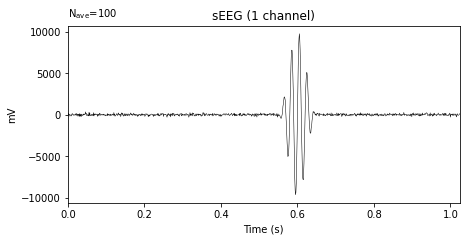

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 100 events and 1025 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Need more than one channel to make topography for seeg. Disabling interactivity.


<ipython-input-70-f027a0938ba8>:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


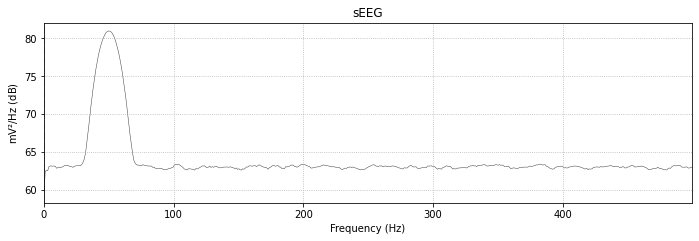

In [70]:
# %%script false --no-raise-error  # 模拟信号生成 Events 和 Epoches

if DATA_SOURCE=='synth':

  # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
  # events 是一系列 event 的列向量
  events = np.zeros((n_epochs, 3), dtype=int)
  events[:, 0] = np.arange(n_epochs) * n_times

  # epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
  # epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
  epochs = Epochs(raw, events, dict(sin50hz=0), tmin=0, tmax=n_times / sfreq,
                  reject=dict(seeg=4000), 
                  baseline=None)


  # 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
  # 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
  epochs.average().plot()

  # 可以画出频率谱看一下
  epochs.plot_psd()
  # for i in range(n_epochs):
      # epochs[i].average().plot()

  # print(events)
  # events


In [71]:
#%%script false --no-raise-error # 真实信号生成 Events 和 Epoches

if DATA_SOURCE=='real':

  # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
  # events 是一系列 event 的列向量
  events = np.zeros((n_epochs, 3), dtype=int)
  events[:, 0] = np.arange(n_epochs) * n_times

  # epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
  # epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
  epochs = Epochs(raw, events, 0, tmin=0, tmax=n_times / sfreq,
                  # reject=dict(seeg=4000), 
                  baseline=None)


  # 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
  # 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
  epochs.average().plot()
  # 可以画出频率谱看一下
  epochs.plot_psd()
  # for i in range(n_epochs):
      # epochs[i].average().plot()



# Draw TFR

In [72]:
fmin=5.
fmax=100.

# scale=current_pixle /to
freqs = np.arange(fmin, fmax, 3.)
vmin, vmax = -3., 3.  # Define our color limits.

freqs

array([ 5.,  8., 11., 14., 17., 20., 23., 26., 29., 32., 35., 38., 41.,
       44., 47., 50., 53., 56., 59., 62., 65., 68., 71., 74., 77., 80.,
       83., 86., 89., 92., 95., 98.])

Using data from preloaded Raw for 100 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


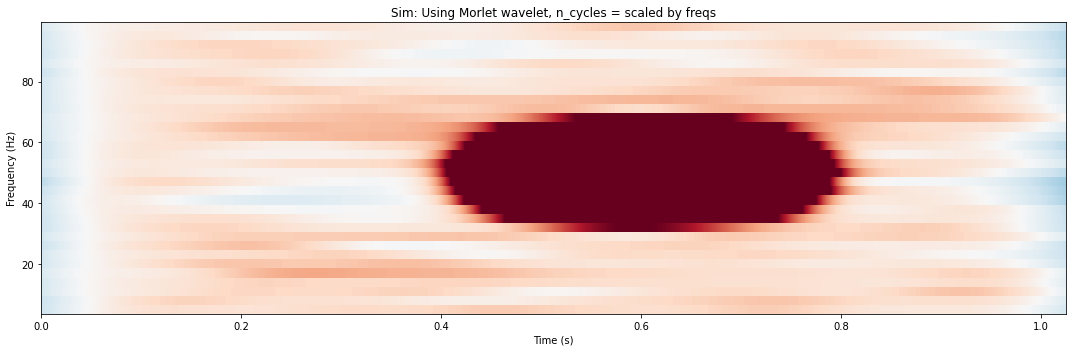

In [73]:
# %%script false --no-raise-error  # 画时频图，一张

fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
# all_n_cycles = [1, 3, freqs / 2.]
# all_n_cycles = [freqs / 2.,freqs / 2.,freqs / 3.,freqs / 4.,freqs / 5.,]
all_n_cycles = [freqs / 2.]
# print(all_n_cycles)
# print(axs)
for n_cycles, ax in zip(all_n_cycles, [axs]):
    power = tfr_morlet(epochs, freqs=freqs,
                       n_cycles=n_cycles, return_itc=False,
                    #    average=False
                       )
    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=False)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title(f'Sim: Using Morlet wavelet, n_cycles = {n_cycles}')
plt.tight_layout()
# all_n_cycles
plt.savefig('output.png')


# Find Hightlights

In [74]:
#@title Functions: Define find highlights functions{display-mode: "form"}
# 定义寻找高光点的函数，内有参数可调。
# find highlight
import scipy.ndimage as ndimg
import numpy as np
from numba import jit
import cv2

def neighbors(shape):
    dim = len(shape)
    block = np.ones([3] * dim)
    block[tuple([1] * dim)] = 0
    idx = np.where(block > 0)
    idx = np.array(idx, dtype=np.uint8).T
    idx = np.array(idx - [1] * dim)
    acc = np.cumprod((1,) + shape[::-1][:-1])
    return np.dot(idx, acc[::-1])


@jit  # trans index to r, c...

def idx2rc(idx, acc):
    rst = np.zeros((len(idx), len(acc)), dtype=np.int16)
    for i in range(len(idx)):
        for j in range(len(acc)):
            rst[i, j] = idx[i] // acc[j]
            idx[i] -= rst[i, j] * acc[j]
    return rst


#@jit  # fill a node (may be two or more points)

def fill(img, msk, p, nbs, buf):
    msk[p] = 3
    buf[0] = p
    back = img[p]
    cur = 0
    s = 1
    while cur < s:
        p = buf[cur]
        for dp in nbs:
            cp = p + dp
            if img[cp] == back and msk[cp] == 1:
                msk[cp] = 3
                buf[s] = cp
                s += 1
                if s == len(buf):
                    buf[:s - cur] = buf[cur:]
                    s -= cur
                    cur = 0
        cur += 1
    #msk[p] = 3


#@jit  # my mark

def mark(img, msk, buf, mode):  # mark the array use (0, 1, 2)
    omark = msk
    nbs = neighbors(img.shape)
    idx = np.zeros(1024 * 128, dtype=np.int64)
    img = img.ravel()  # 降维
    msk = msk.ravel()  # 降维
    s = 0
    for p in range(len(img)):
        if msk[p] != 1: continue
        flag = False
        for dp in nbs:
            if mode and img[p + dp] > img[p]:
                flag = True
                break
            elif not mode and img[p + dp] < img[p]:
                flag = True
                break

        if flag : continue
        else    : fill(img, msk, p, nbs, buf)
        idx[s] = p
        s += 1
        if s == len(idx): break
    plt.imshow(omark, cmap='gray')
    return idx[:s].copy()



def filter(img, msk, idx, bur, tor, mode):
    omark = msk
    nbs = neighbors(img.shape)
    acc = np.cumprod((1,) + img.shape[::-1][:-1])[::-1]
    img = img.ravel()
    msk = msk.ravel()

    arg = np.argsort(img[idx])[::-1 if mode else 1]

    for i in arg:
        if msk[idx[i]] != 3:
            idx[i] = 0
            continue
        cur = 0
        s = 1
        bur[0] = idx[i]
        while cur < s:
            p = bur[cur]
            if msk[p] == 2:
                idx[i] = 0
                break

            for dp in nbs:
                cp = p + dp
                if msk[cp] == 0 or cp == idx[i] or msk[cp] == 4: continue
                if mode and img[cp] < img[idx[i]] - tor: continue
                if not mode and img[cp] > img[idx[i]] + tor: continue
                bur[s] = cp
                s += 1
                if s == 1024 * 128:
                    cut = cur // 2
                    msk[bur[:cut]] = 2
                    bur[:s - cut] = bur[cut:]
                    cur -= cut
                    s -= cut

                if msk[cp] != 2: msk[cp] = 4
            cur += 1
        msk[bur[:s]] = 2
        #plt.imshow(omark, cmap='gray')

    return idx2rc(idx[idx > 0], acc)


def find_maximum(img, tor, mode=True):
    msk = np.zeros_like(img, dtype=np.uint8)
    msk[tuple([slice(1, -1)] * img.ndim)] = 1
    buf = np.zeros(1024 * 128, dtype=np.int64)
    omark = msk
    idx = mark(img, msk, buf, mode)
    plt.imshow(msk, cmap='gray')
    idx = filter(img, msk, idx, buf, tor, mode)
    return idx

# 寻找高光点主函数
def find_highlight(filepath):
 # from scipy.misc import imread
    from imageio import imread
    from scipy.ndimage import gaussian_filter
    from time import time
    import matplotlib.pyplot as plt

    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.bitwise_not(img) # invert color
    ret2, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img[:] = ndimg.distance_transform_edt(img)
    plt.imshow(img, cmap='gray')
    # pts = find_maximum(img, 20, True)
    start = time()
    pts = find_maximum(img, 15, True)  ######### 这个参数可调识别阈值
    print(time() - start)
    print(pts)
    plt.imshow(img, cmap='gray')
    plt.plot(pts[:, 1], pts[:, 0], 'y.')
    plt.show()
# This code will be hidden when the notebook is loaded.


38.12993335723877
[[176 586]]


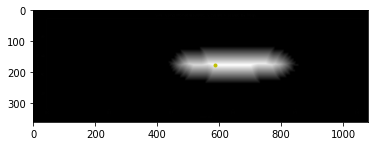

In [75]:
# %%script false --no-raise-error
if FIND_HIGHLIGHT==True:
  find_highlight('output.png')

In [76]:
times=np.array([1.5,2.5,40,50,60,70,80,90,100]) # 单位 s
sample_times=times*sfreq #换算成 sample
n_epochs=len(times)

# event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
# events 是一系列 event 的列向量
events = np.zeros((n_epochs, 3), dtype=int)
events[:, 0] = sample_times
# events

In [77]:

# epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
# epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
epochs = Epochs(raw, events, 0, tmin=-1, tmax=1,
                # reject=dict(seeg=4000), 
                baseline=None)


# 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
# 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
# epochs.average().plot()
# epochs.plot_psd()
# epochs.plot_image()


Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated


# Clustering

In [78]:
#@title custom metric {display-mode: "form"}

def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [79]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import calinski_harabasz_score

from tslearn.clustering import TimeSeriesKMeans


# bandpass filter
# fmin=0
# fmax=10
# raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
#                l_trans_bandwidth=1,  # make sure filter params are the same
#                h_trans_bandwidth=1)  # in each band and skip "auto" option.

# from dtaidistance import dtw
# dist_dtai = dtw.distance_fast(a[0], a[1])


source=epochs.get_data()[:,0]
best_score = 0
best_pre = []
best_cluster_num = 0
for index, k in enumerate((2,3,4,5,6,7)):
# for index, k in enumerate((4,)):
    # 选择模型, 默认 Kmeans
    # TimeSeriesDTW, DBSCAN, ward, Kmeans
    # model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
    # model = DBSCAN(eps=14, min_samples=2, metric=lambda a, b: DTW(a, b))
    # model = AgglomerativeClustering(n_clusters = k, linkage = 'ward', metric=DTW)
    model=KMeans(n_clusters=k, random_state=666)
    y_pre = model.fit_predict(source)
    print(y_pre)
    score = calinski_harabasz_score(source, y_pre)
    print(score)
    if score > best_score:
        best_score = score
        best_pre = y_pre
        best_cluster_num = k
        best_model=model

best_cluster_num

Using data from preloaded Raw for 9 events and 2001 original time points ...
0 bad epochs dropped
[0 0 1 1 0 0 0 1 0]
1.0802013329065203
[0 0 2 2 1 1 1 2 1]
1.1151311310638035
[1 1 3 2 3 0 3 2 0]
1.106073520000501
[0 0 4 2 0 0 3 0 1]
1.0799064085879546
[1 3 0 2 1 1 5 1 4]
1.0787930862697739
[1 1 2 6 0 0 3 4 5]
1.1660522507763285


7

# Ploting

In [80]:
#@title Function: Print segment by sample location {display-mode: "form"}

# 根据 sample 位置打印前后片段
def print_sample(first_sample):
    _events = np.zeros((1, 3), dtype=int)
    _events[:, 0] = [first_sample]
    _epochs = Epochs(raw, events, 0, tmin=-1, tmax=1,
                # reject=dict(seeg=4000), 
                baseline=None)
    # epochs.average().plot(title=str(first_sample))
    _epochs.average().plot(titles='segment at sample: '+str(first_sample))


## Plot Clusters

KMeans(n_clusters=7, random_state=666)
lab = 1 [ 0.92617755  1.90941664 -1.39856757 ...  0.7903719   0.34005129
  0.570613  ] original_index = 0
1500
lab = 1 [ 0.77836108 -0.55118572 -0.81819888 ... -0.18315047 -0.35667313
  1.18064091] original_index = 1
2500
lab = 2 [ 0.37398056  0.16459805  0.08790581 ...  1.2640864  -0.64479945
 -0.5717916 ] original_index = 2
40000
lab = 6 [ 2.41424789 -0.63656254  0.54385869 ...  1.97172087 -1.86059295
 -0.08286876] original_index = 3
50000
lab = 0 [-1.97931007 -1.42328666 -0.73122711 ...  3.24787807  4.51640586
  6.0772038 ] original_index = 4
60000
lab = 0 [ 0.47351997 -1.28188014  2.66731499 ... -0.50328948  1.92650205
 -0.75669935] original_index = 5
70000
lab = 3 [-1.09471311  0.56693732  0.05920258 ...  0.41683345 -0.0251913
 -0.87485889] original_index = 6
80000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


lab = 4 [ 1.36817372 -0.23212574 -0.00416487 ... -0.89719161  0.76483458
 -0.87578135] original_index = 7
90000
lab = 5 [ 1.35609217 -0.5400079  -0.03089371 ...  0.00480932 -1.04531381
  1.17020869] original_index = 8
100000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

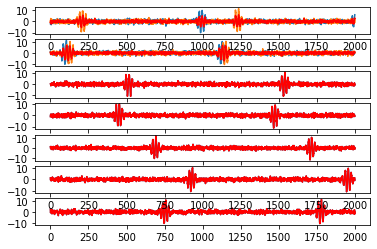

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


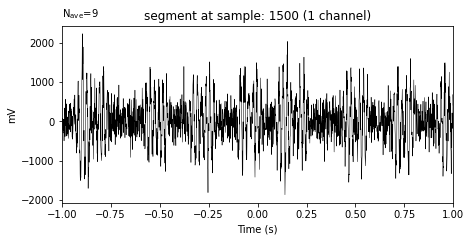

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


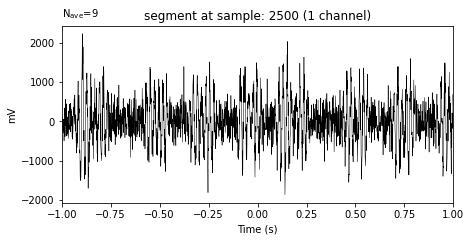

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


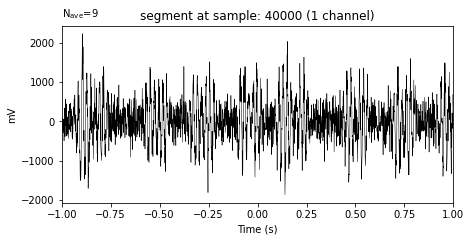

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


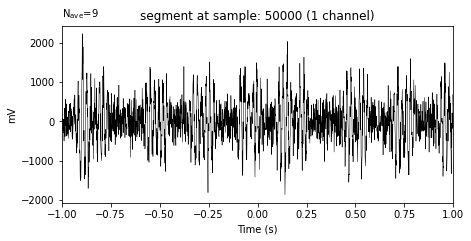

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


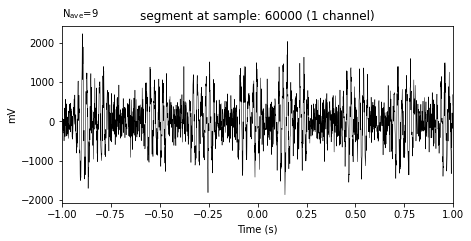

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


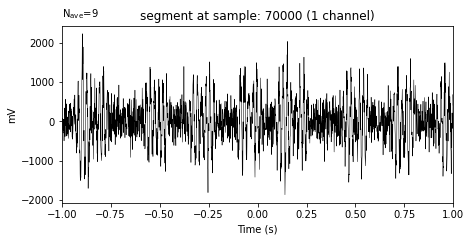

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


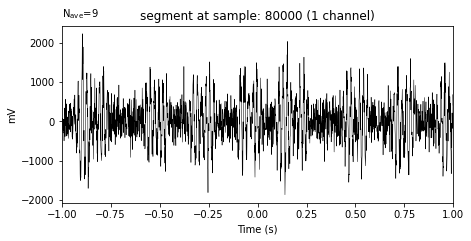

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


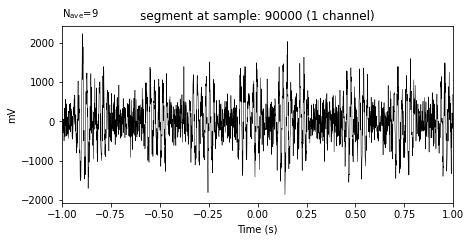

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


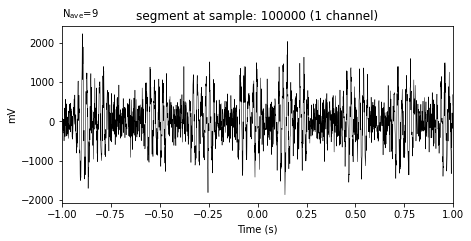

In [81]:
# Muk = best_model.cluster_centers_  # 聚类中心
# C_i = best_model.predict(source)   # 类别列表

nSample, nDim = source.shape
labs = np.unique(best_pre)
means = np.zeros((len(labs),nDim))
for i, lab in enumerate(labs):
    means[i] = np.mean(source[best_pre == lab], axis=0)
Muk=means  # 聚类中心
print(best_model)
if hasattr(best_model, "labels_"):
    y_pred = best_model.labels_.astype(int)
else:
    y_pred = best_model.predict(X)
C_i = y_pred  # 类别列表

# catch_trials_and_buttonpresses = mne.pick_events(events, include=[5, 32])
# epochs.plot(events=events, event_id=0         )

# 一次循环
for original_index,(point,lab) in enumerate(zip(source,C_i)):
    # print(f'lab={lab}')
    print('lab =',lab, point,'original_index =', original_index)
    print(events[original_index][0])
    # print_sample(events[original_index][0])
    # epochs[original_index].plot()
    plt.subplot(Muk.shape[0],1,lab+1)
    plt.plot(np.arange(point.size),point)   # 绘制类内 sample
for index, (center,lab) in enumerate(zip(Muk,np.unique(C_i))):
    plt.subplot(Muk.shape[0], 1, index+1)
    plt.plot(np.arange(center.size),center,color='red' )   # 红色绘制聚类中心
plt.show()

# 打印原始原始片段
for original_index,(point,lab) in enumerate(zip(source,C_i)):
    print_sample(events[original_index][0])
